In [1]:
import os
import numpy as np
import pandas as pd
from pandas import Timestamp
import seaborn as sns
import matplotlib.pyplot as plt
#
from talib import RSI, BBANDS, MACD, ATR
#
from zipline.api import order_target_percent, record, symbol, set_benchmark, get_open_orders
import zipline
import datetime
import pytz
from zipline.data.bundles import load
from trading_calendars import get_calendar
import pyfolio as pf
#
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
#
from matplotlib.ticker import FuncFormatter
%load_ext zipline

# Data load

In [2]:
df = pd.read_csv("/Users/dashavasileva/Desktop/ape_mining/data/signals/General_Factors.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.index = pd.MultiIndex.from_frame(df.iloc[:,0:2])
df = df.dropna()
df = df.drop(["Symbol", "Date"], axis=1)
df

Open      High       Low     Close        Volume  \
Symbol Date                                                               
ADA    2018-06-11  0.177891  0.181702  0.168733  0.180109  1.004216e+08   
       2018-06-12  0.180272  0.182289  0.163364  0.165864  6.949217e+07   
       2018-06-13  0.166002  0.168108  0.152398  0.160494  7.014928e+07   
       2018-06-14  0.160082  0.174866  0.154828  0.172610  1.431842e+08   
       2018-06-15  0.172513  0.172513  0.163844  0.164626  8.906098e+07   
...                     ...       ...       ...       ...           ...   
TFUEL  2022-03-16  0.159951  0.164327  0.156638  0.163232  2.340533e+07   
       2022-03-17  0.163232  0.168716  0.160215  0.166944  2.249906e+07   
       2022-03-18  0.167122  0.176702  0.163110  0.170451  2.254040e+07   
       2022-03-19  0.170140  0.175788  0.166374  0.172212  2.129223e+07   
       2022-03-20  0.172198  0.172228  0.165948  0.167006  1.999143e+07   

                         rsi   bb_high    bb_low       atr      macd  ...  \
Symbol Date                                                           ...   
ADA    2018-06-11  33.512455  0.216036  0.021987 -0.404601 -0.349924  ...   
       2018-06-12  30.063208  0.269702 -0.021351 -0.405151 -0.383543  ...   
       2018-06-13  28.857432  0.291623 -0.010164 -0.409419 -0.413876  ...   
       2018-06-14  35.174686  0.254994  0.077835 -0.408323 -0.416873  ...   
       2018-06-15  33.089452  0.282673  0.061770 -0.420484 -0.426485  ...   
...                      ...       ...       ...       ...       ...  ...   
TFUEL  2022-03-16  47.924529  0.091847  0.112104  0.145477 -0.495777  ...   
       2022-03-17  50.268468  0.071962  0.129365  0.125531 -0.423620  ...   
       2022-03-18  52.445625  0.054721  0.145075  0.130008 -0.340504  ...   
       2022-03-19  53.545190  0.050250  0.152796  0.115289 -0.260929  ...   
       2022-03-20  49.873470  0.064820  0.124119  0.087470 -0.229633  ...   

                   month_3  month_4  month_5  month_6  month_7  month_8  \
Symbol Date                                                               
ADA    2018-06-11        0        0        0        1        0        0   
       2018-06-12        0        0        0        1        0        0   
       2018-06-13        0        0        0        1        0        0   
       2018-06-14        0        0        0        1        0        0   
       2018-06-15        0        0        0        1        0        0   
...                    ...      ...      ...      ...      ...      ...   
TFUEL  2022-03-16        1        0        0        0        0        0   
       2022-03-17        1        0        0        0        0        0   
       2022-03-18        1        0        0        0        0        0   
       2022-03-19        1        0        0        0        0        0   
       2022-03-20        1        0        0        0        0        0   

                   month_9  month_10  month_11  month_12  
Symbol Date                                               
ADA    2018-06-11        0         0         0         0  
       2018-06-12        0         0         0         0  
       2018-06-13        0         0         0         0  
       2018-06-14        0         0         0         0  
       2018-06-15        0         0         0         0  
...                    ...       ...       ...       ...  
TFUEL  2022-03-16        0         0         0         0  
       2022-03-17        0         0         0         0  
       2022-03-18        0         0         0         0  
       2022-03-19        0         0         0         0  
       2022-03-20        0         0         0         0  

[9653 rows x 125 columns]

In [3]:
# what are lagged returns used for
df = df.drop([c for c in df.columns if 'lag' in c], axis=1)

In [4]:
df = df.drop(['Open', 'High', 'Low', 'Close'], axis=1)


## Splitting Data

In [5]:
# Machine Learning for Algorithmic Trading Chapter 6
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='Date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates[self.date_idx] <= days[train_end])].index
            test_idx = dates[(dates[self.date_idx] > days[test_start])
                             & (dates[self.date_idx] <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [6]:
y = df.filter(like='target')
X = df.drop(y.columns, axis=1)
X = X.drop(['Volume'], axis=1)

In [7]:
MONTH = 12
YEAR = 12 * MONTH
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR/test_period_length)
lookahead = 1

# cross-validation
cv = MultipleTimeSeriesCV(n_splits=n_splits,
    test_period_length=test_period_length,
    lookahead=lookahead,
    train_period_length=train_period_length)

In [8]:
i = 0
for train_idx, test_idx in cv.split(X=df):
    train = df.iloc[train_idx]
    train_dates = train.index.get_level_values('Date')
    test = df.iloc[test_idx]
    test_dates = test.index.get_level_values('Date')
    dff = train.reset_index().append(test.reset_index())
    n = len(dff)
    assert n== len(dff.drop_duplicates())
    print(train.groupby(level='Symbol').size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          test.groupby(level='Symbol').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10:
        break

63 2022-01-07 2022-03-10 10 2022-03-11 2022-03-20
63 2021-12-28 2022-02-28 10 2022-03-01 2022-03-10
63 2021-12-18 2022-02-18 10 2022-02-19 2022-02-28
63 2021-12-08 2022-02-08 10 2022-02-09 2022-02-18
63 2021-11-28 2022-01-29 10 2022-01-30 2022-02-08
63 2021-11-18 2022-01-19 10 2022-01-20 2022-01-29
63 2021-11-08 2022-01-09 10 2022-01-10 2022-01-19
63 2021-10-29 2021-12-30 10 2021-12-31 2022-01-09
63 2021-10-19 2021-12-20 10 2021-12-21 2021-12-30
63 2021-10-09 2021-12-10 10 2021-12-11 2021-12-20


## Plotting Functions

In [9]:
def plot_preds_scatter(df, ticker=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True, ci=None,
                      line_kws={'lw': 1, 'color': 'k'},
                      scatter_kws={'s': 1},
                      data=df,
                      kind='reg')
    j.ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j.ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j.ax_joint.set_xlabel('Predicted')
    j.ax_joint.set_ylabel('Actuals')

In [10]:
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9,
            s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

In [11]:
def plot_rolling_ic(df):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    mean_ic = df.ic.mean()
    rolling_result.ic.plot(ax=axes[0],
                           title=f'Information Coefficient (Mean: {mean_ic:.2f})',
                           lw=1)
    axes[0].axhline(0, lw=.5, ls='-', color='k')
    axes[0].axhline(mean_ic, lw=1, ls='--', color='k')

    mean_rmse = df.rmse.mean()
    rolling_result.rmse.plot(ax=axes[1],
                             title=f'Root Mean Squared Error (Mean: {mean_rmse:.2%})',
                             lw=1,
                             ylim=(0, df.rmse.max()))
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')
    sns.despine()
    plt.tight_layout()

## Linear Regression (general factors)

In [12]:
%%time
target = f'target_{lookahead}d'
lr_predictions, lr_scores = [], []
lr = LinearRegression()
for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
    lr.fit(X=X_train, y=y_train)
    y_pred = lr.predict(X_test)

    preds = y_test.to_frame('actuals').assign(predicted=y_pred)
    preds_by_day = preds.groupby(level='Date')
    scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                               x.actuals)[0] * 100)
                        .to_frame('ic'),
                        preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                y_true=x.actuals)))
                        .to_frame('rmse')], axis=1)

    lr_scores.append(scores)
    lr_predictions.append(preds)

lr_scores = pd.concat(lr_scores)
lr_predictions = pd.concat(lr_predictions)

CPU times: user 7.17 s, sys: 416 ms, total: 7.59 s
Wall time: 1.27 s


In [13]:
lr_r, lr_p = spearmanr(lr_predictions.actuals, lr_predictions.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})')

Information Coefficient (overall): 3.994% (p-value: 2.8430%)


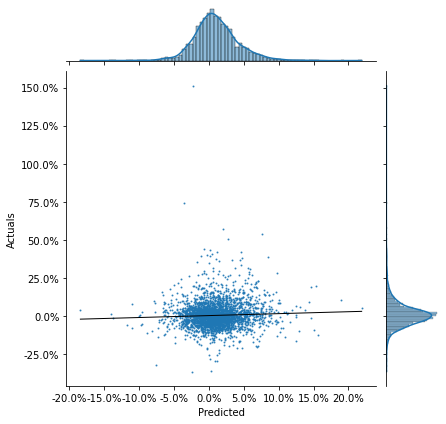

In [14]:
plot_preds_scatter(lr_predictions)

/Users/dashavasileva/opt/anaconda3/envs/envzipline/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


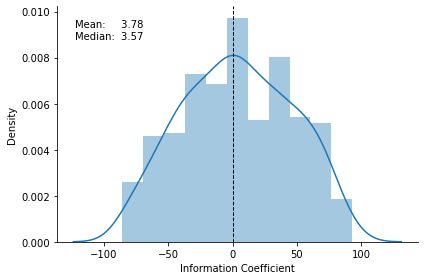

In [15]:
plot_ic_distribution(lr_scores)

## Linear Regression (General Factors + Simulated Sentiment)

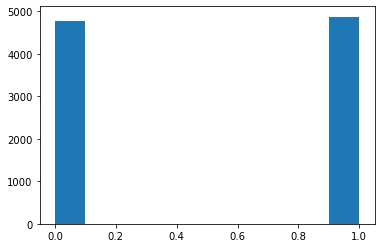

In [16]:
day_range = df.index.get_level_values('Date').unique()

simulated_sentiment_arr = np.tile(np.random.randint(0, 2, len(day_range)),7)
_ = plt.hist(simulated_sentiment_arr)

In [17]:
df['sentiment'] = simulated_sentiment_arr

In [18]:
df

Volume        rsi   bb_high    bb_low       atr  \
Symbol Date                                                                
ADA    2018-06-11  1.004216e+08  33.512455  0.216036  0.021987 -0.404601   
       2018-06-12  6.949217e+07  30.063208  0.269702 -0.021351 -0.405151   
       2018-06-13  7.014928e+07  28.857432  0.291623 -0.010164 -0.409419   
       2018-06-14  1.431842e+08  35.174686  0.254994  0.077835 -0.408323   
       2018-06-15  8.906098e+07  33.089452  0.282673  0.061770 -0.420484   
...                         ...        ...       ...       ...       ...   
TFUEL  2022-03-16  2.340533e+07  47.924529  0.091847  0.112104  0.145477   
       2022-03-17  2.249906e+07  50.268468  0.071962  0.129365  0.125531   
       2022-03-18  2.254040e+07  52.445625  0.054721  0.145075  0.130008   
       2022-03-19  2.129223e+07  53.545190  0.050250  0.152796  0.115289   
       2022-03-20  1.999143e+07  49.873470  0.064820  0.124119  0.087470   

                       macd  return_1d  return_2d  return_3d  return_4d  ...  \
Symbol Date                                                              ...   
ADA    2018-06-11 -0.349924   0.011576  -0.062333  -0.044647  -0.038902  ...   
       2018-06-12 -0.383543  -0.079092  -0.034822  -0.067953  -0.053377  ...   
       2018-06-13 -0.413876  -0.032376  -0.056023  -0.034007  -0.059183  ...   
       2018-06-14 -0.416873   0.075489   0.020132  -0.014077  -0.007726  ...   
       2018-06-15 -0.426485  -0.046255   0.012789  -0.002495  -0.022222  ...   
...                     ...        ...        ...        ...        ...  ...   
TFUEL  2022-03-16 -0.495777   0.020510   0.004641   0.011658   0.000422  ...   
       2022-03-17 -0.423620   0.022745   0.021627   0.010640   0.014418  ...   
       2022-03-18 -0.340504   0.021005   0.021875   0.021420   0.013221  ...   
       2022-03-19 -0.260929   0.010329   0.015653   0.018012   0.018636  ...   
       2022-03-20 -0.229633  -0.030225  -0.010156   0.000124   0.005732  ...   

                   month_4  month_5  month_6  month_7  month_8  month_9  \
Symbol Date                                                               
ADA    2018-06-11        0        0        1        0        0        0   
       2018-06-12        0        0        1        0        0        0   
       2018-06-13        0        0        1        0        0        0   
       2018-06-14        0        0        1        0        0        0   
       2018-06-15        0        0        1        0        0        0   
...                    ...      ...      ...      ...      ...      ...   
TFUEL  2022-03-16        0        0        0        0        0        0   
       2022-03-17        0        0        0        0        0        0   
       2022-03-18        0        0        0        0        0        0   
       2022-03-19        0        0        0        0        0        0   
       2022-03-20        0        0        0        0        0        0   

                   month_10  month_11  month_12  sentiment  
Symbol Date                                                 
ADA    2018-06-11         0         0         0          1  
       2018-06-12         0         0         0          0  
       2018-06-13         0         0         0          0  
       2018-06-14         0         0         0          0  
       2018-06-15         0         0         0          0  
...                     ...       ...       ...        ...  
TFUEL  2022-03-16         0         0         0          1  
       2022-03-17         0         0         0          1  
       2022-03-18         0         0         0          1  
       2022-03-19         0         0         0          0  
       2022-03-20         0         0         0          1  

[9653 rows x 41 columns]

In [19]:
y = df.filter(like='target')
X = df.drop(y.columns, axis=1)
X = X.drop(['Volume'], axis=1)

In [20]:
%%time
target = f'target_{lookahead}d'
lr_predictions, lr_scores = [], []
lr = LinearRegression()
for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
    lr.fit(X=X_train, y=y_train)
    y_pred = lr.predict(X_test)

    preds = y_test.to_frame('actuals').assign(predicted=y_pred)
    preds_by_day = preds.groupby(level='Date')
    scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                               x.actuals)[0] * 100)
                        .to_frame('ic'),
                        preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                y_true=x.actuals)))
                        .to_frame('rmse')], axis=1)

    lr_scores.append(scores)
    lr_predictions.append(preds)

lr_scores = pd.concat(lr_scores)
lr_predictions = pd.concat(lr_predictions)

CPU times: user 7.56 s, sys: 598 ms, total: 8.16 s
Wall time: 1.28 s


In [21]:
lr_r, lr_p = spearmanr(lr_predictions.actuals, lr_predictions.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})')

Information Coefficient (overall): 2.562% (p-value: 15.9982%)


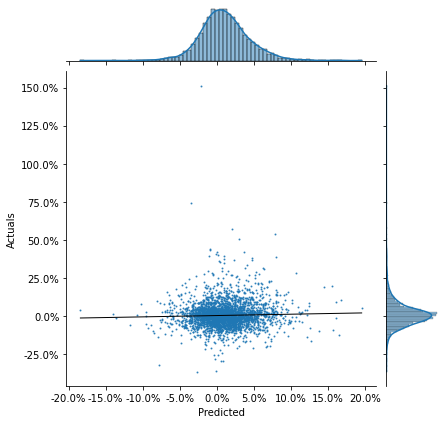

In [22]:
plot_preds_scatter(lr_predictions)

/Users/dashavasileva/opt/anaconda3/envs/envzipline/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


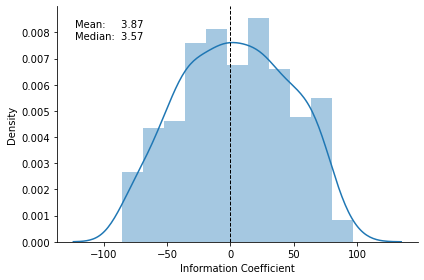

In [23]:
plot_ic_distribution(lr_scores)

## Examination

In [24]:
y

target_1d  target_2d  target_3d  target_4d  target_5d  \
Symbol Date                                                                
ADA    2018-06-11  -0.079092  -0.056023  -0.014077  -0.022222  -0.019274   
       2018-06-12  -0.032376   0.020132  -0.002495  -0.003722  -0.005159   
       2018-06-13   0.075489   0.012789   0.006017   0.001764   0.004719   
       2018-06-14  -0.046255  -0.027018  -0.021671  -0.012234  -0.006675   
       2018-06-15  -0.007393  -0.009142  -0.000626   0.003474  -0.003113   
...                      ...        ...        ...        ...        ...   
TFUEL  2022-03-16   0.022745   0.021875   0.018012   0.005732   0.006166   
       2022-03-17   0.021005   0.015653   0.000124   0.002063   0.003742   
       2022-03-18   0.010329  -0.010156  -0.004172  -0.000528   0.004854   
       2022-03-19  -0.030225  -0.011345  -0.004121   0.003490   0.009399   
       2022-03-20   0.007903   0.009193   0.014987   0.019555   0.015191   

                   target_6d  target_7d  target_14d  target_28d  
Symbol Date                                                      
ADA    2018-06-11  -0.017881  -0.013024   -0.020143   -0.008853  
       2018-06-12  -0.001561   0.000911   -0.019162   -0.008869  
       2018-06-13   0.006569   0.001405   -0.016410   -0.007186  
       2018-06-14  -0.010437  -0.012066   -0.025488   -0.011087  
       2018-06-15  -0.006250  -0.022649   -0.020334   -0.006514  
...                      ...        ...         ...         ...  
TFUEL  2022-03-16   0.006885   0.009688    0.013518    0.001409  
       2022-03-17   0.007528   0.011182    0.016350   -0.000717  
       2022-03-18   0.009554   0.007883    0.015864   -0.000663  
       2022-03-19   0.007476   0.009547    0.016414   -0.001336  
       2022-03-20   0.016332   0.022270    0.018807   -0.001178  

[9653 rows x 9 columns]

In [25]:
lr_predictions

actuals  predicted
Symbol Date                           
ADA    2022-03-11 -0.000597  -0.008557
       2022-03-12  0.000548  -0.031043
       2022-03-13  0.015078  -0.013886
       2022-03-14 -0.003871  -0.006821
       2022-03-15  0.049287  -0.016523
...                     ...        ...
TFUEL  2021-01-20 -0.162679   0.035721
       2021-01-21  0.093144   0.035706
       2021-01-22  0.076568   0.064270
       2021-01-23 -0.032626   0.039840
       2021-01-24  0.025719   0.033853

[3010 rows x 2 columns]

## Random Forest Regressor


In [26]:
%%time
target = f'target_{lookahead}d'
rf_predictions, rf_scores = [], []
rf = RandomForestRegressor(random_state=0)
for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
    rf.fit(X=X_train, y=y_train)
    y_pred = rf.predict(X_test)

    preds = y_test.to_frame('actuals').assign(predicted=y_pred)
    preds_by_day = preds.groupby(level='Date')
    scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                               x.actuals)[0] * 100)
                        .to_frame('ic'),
                        preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                y_true=x.actuals)))
                        .to_frame('rmse')], axis=1)

    rf_scores.append(scores)
    rf_predictions.append(preds)

rf_scores = pd.concat(rf_scores)
rf_predictions = pd.concat(rf_predictions)

CPU times: user 20.5 s, sys: 342 ms, total: 20.9 s
Wall time: 21.2 s


In [27]:
rf_r, rf_p = spearmanr(rf_predictions.actuals, rf_predictions.predicted)
print(f'Information Coefficient (overall): {rf_r:.3%} (p-value: {rf_p:.4%})')

Information Coefficient (overall): 4.956% (p-value: 0.6534%)


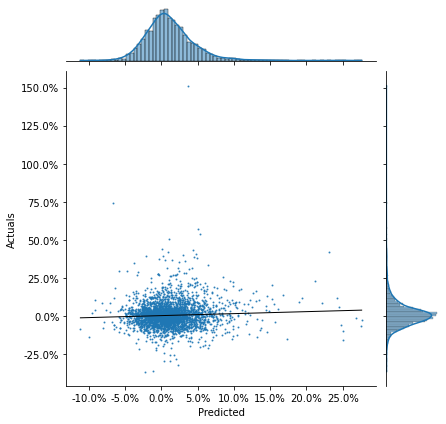

In [28]:
plot_preds_scatter(rf_predictions)

## Adding NFT_markettracker.csv

In [29]:
df2 = pd.read_csv("/Users/dashavasileva/Desktop/ape_mining/data/NFT_markettracker.csv")

In [30]:
df2.columns

Index(['Unnamed: 0', 'Date', 'Number of sales', 'Sales USD', 'Average USD',
       'Active market wallets', 'Primary Sales', 'Secondary sales',
       'Primary sales USD', 'Secondary sales USD', 'Unique buyers',
       'Unique sellers'],
      dtype='object')

In [31]:
df2.drop(['Unnamed: 0'], axis=1, inplace=True)

In [32]:
df

Volume        rsi   bb_high    bb_low       atr  \
Symbol Date                                                                
ADA    2018-06-11  1.004216e+08  33.512455  0.216036  0.021987 -0.404601   
       2018-06-12  6.949217e+07  30.063208  0.269702 -0.021351 -0.405151   
       2018-06-13  7.014928e+07  28.857432  0.291623 -0.010164 -0.409419   
       2018-06-14  1.431842e+08  35.174686  0.254994  0.077835 -0.408323   
       2018-06-15  8.906098e+07  33.089452  0.282673  0.061770 -0.420484   
...                         ...        ...       ...       ...       ...   
TFUEL  2022-03-16  2.340533e+07  47.924529  0.091847  0.112104  0.145477   
       2022-03-17  2.249906e+07  50.268468  0.071962  0.129365  0.125531   
       2022-03-18  2.254040e+07  52.445625  0.054721  0.145075  0.130008   
       2022-03-19  2.129223e+07  53.545190  0.050250  0.152796  0.115289   
       2022-03-20  1.999143e+07  49.873470  0.064820  0.124119  0.087470   

                       macd  return_1d  return_2d  return_3d  return_4d  ...  \
Symbol Date                                                              ...   
ADA    2018-06-11 -0.349924   0.011576  -0.062333  -0.044647  -0.038902  ...   
       2018-06-12 -0.383543  -0.079092  -0.034822  -0.067953  -0.053377  ...   
       2018-06-13 -0.413876  -0.032376  -0.056023  -0.034007  -0.059183  ...   
       2018-06-14 -0.416873   0.075489   0.020132  -0.014077  -0.007726  ...   
       2018-06-15 -0.426485  -0.046255   0.012789  -0.002495  -0.022222  ...   
...                     ...        ...        ...        ...        ...  ...   
TFUEL  2022-03-16 -0.495777   0.020510   0.004641   0.011658   0.000422  ...   
       2022-03-17 -0.423620   0.022745   0.021627   0.010640   0.014418  ...   
       2022-03-18 -0.340504   0.021005   0.021875   0.021420   0.013221  ...   
       2022-03-19 -0.260929   0.010329   0.015653   0.018012   0.018636  ...   
       2022-03-20 -0.229633  -0.030225  -0.010156   0.000124   0.005732  ...   

                   month_4  month_5  month_6  month_7  month_8  month_9  \
Symbol Date                                                               
ADA    2018-06-11        0        0        1        0        0        0   
       2018-06-12        0        0        1        0        0        0   
       2018-06-13        0        0        1        0        0        0   
       2018-06-14        0        0        1        0        0        0   
       2018-06-15        0        0        1        0        0        0   
...                    ...      ...      ...      ...      ...      ...   
TFUEL  2022-03-16        0        0        0        0        0        0   
       2022-03-17        0        0        0        0        0        0   
       2022-03-18        0        0        0        0        0        0   
       2022-03-19        0        0        0        0        0        0   
       2022-03-20        0        0        0        0        0        0   

                   month_10  month_11  month_12  sentiment  
Symbol Date                                                 
ADA    2018-06-11         0         0         0          1  
       2018-06-12         0         0         0          0  
       2018-06-13         0         0         0          0  
       2018-06-14         0         0         0          0  
       2018-06-15         0         0         0          0  
...                     ...       ...       ...        ...  
TFUEL  2022-03-16         0         0         0          1  
       2022-03-17         0         0         0          1  
       2022-03-18         0         0         0          1  
       2022-03-19         0         0         0          0  
       2022-03-20         0         0         0          1  

[9653 rows x 41 columns]

In [33]:
df.index

MultiIndex([(  'ADA', '2018-06-11'),
            (  'ADA', '2018-06-12'),
            (  'ADA', '2018-06-13'),
            (  'ADA', '2018-06-14'),
            (  'ADA', '2018-06-15'),
            (  'ADA', '2018-06-16'),
            (  'ADA', '2018-06-17'),
            (  'ADA', '2018-06-18'),
            (  'ADA', '2018-06-19'),
            (  'ADA', '2018-06-20'),
            ...
            ('TFUEL', '2022-03-11'),
            ('TFUEL', '2022-03-12'),
            ('TFUEL', '2022-03-13'),
            ('TFUEL', '2022-03-14'),
            ('TFUEL', '2022-03-15'),
            ('TFUEL', '2022-03-16'),
            ('TFUEL', '2022-03-17'),
            ('TFUEL', '2022-03-18'),
            ('TFUEL', '2022-03-19'),
            ('TFUEL', '2022-03-20')],
           names=['Symbol', 'Date'], length=9653)

In [34]:
int_date = df.index.get_level_values('Date')[0]

In [35]:
df2.Date = pd.to_datetime(df2['Date'])

In [36]:
df2.head()

,Date,Number of sales,Sales USD,Average USD,Active market wallets,Primary Sales,Secondary sales,Primary sales USD,Secondary sales USD,Unique buyers,Unique sellers
0,2017-10-02,0,0.00,NaN,0,0,0,0.0,0.00,0,0
1,2017-10-03,0,0.00,NaN,0,0,0,0.0,0.00,0,0
2,2017-10-04,1,58.61,58.61,2,0,1,0.0,58.61,1,1
3,2017-10-05,0,0.00,NaN,0,0,0,0.0,0.00,0,0
4,2017-10-06,0,0.00,NaN,0,0,0,0.0,0.00,0,0


In [37]:
df3 = df2[df2.Date >= int_date]

In [38]:
df3

,Date,Number of sales,Sales USD,Average USD,Active market wallets,Primary Sales,Secondary sales,Primary sales USD,Secondary sales USD,Unique buyers,Unique sellers
252,2018-06-11,3381,42601.19,12.60,660,2864,517,20244.22,22356.97,492,280
253,2018-06-12,2903,36981.38,12.74,692,2296,607,18200.13,18781.24,504,294
254,2018-06-13,2272,51268.92,22.57,718,1671,601,23514.14,27754.78,527,283
255,2018-06-14,1926,45763.29,23.76,566,1556,370,14447.34,31315.95,432,205
256,2018-06-15,5253,50514.50,9.62,641,4665,588,26308.40,24206.09,450,280
...,...,...,...,...,...,...,...,...,...,...,...
1654,2022-04-13,27016,36799249.28,1362.13,23092,3169,23847,1939272.26,34859977.03,13794,11991
1655,2022-04-14,27159,36058938.73,1327.70,23008,3915,23244,1601773.90,34457164.83,13678,12034
1656,2022-04-15,13542,27940930.86,2063.28,12057,5188,8354,1751963.53,26188967.34,6936,5862
1657,2022-04-16,29586,26894315.89,909.02,23214,4714,24872,1715429.53,25178886.36,13788,11851


In [42]:
new_array = np.tile(df3, (7,1))
df4 = pd.DataFrame(new_array , columns=df3.columns)

In [43]:
df4

,Date,Number of sales,Sales USD,Average USD,Active market wallets,Primary Sales,Secondary sales,Primary sales USD,Secondary sales USD,Unique buyers,Unique sellers
0,2018-06-11,3381,42601.19,12.6,660,2864,517,20244.22,22356.97,492,280
1,2018-06-12,2903,36981.38,12.74,692,2296,607,18200.13,18781.24,504,294
2,2018-06-13,2272,51268.92,22.57,718,1671,601,23514.14,27754.78,527,283
3,2018-06-14,1926,45763.29,23.76,566,1556,370,14447.34,31315.95,432,205
4,2018-06-15,5253,50514.5,9.62,641,4665,588,26308.4,24206.09,450,280
...,...,...,...,...,...,...,...,...,...,...,...
9844,2022-04-13,27016,36799249.28,1362.13,23092,3169,23847,1939272.26,34859977.03,13794,11991
9845,2022-04-14,27159,36058938.73,1327.7,23008,3915,23244,1601773.9,34457164.83,13678,12034
9846,2022-04-15,13542,27940930.86,2063.28,12057,5188,8354,1751963.53,26188967.34,6936,5862
9847,2022-04-16,29586,26894315.89,909.02,23214,4714,24872,1715429.53,25178886.36,13788,11851


In [50]:
pd.concat([df, df4.drop('Date', axis=1)], axis=1, ignore_index=True)

NotImplementedError: Can only union MultiIndex with MultiIndex or Index of tuples, try mi.to_flat_index().union(other) instead.